In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, Normalizer
from sklearn.model_selection import train_test_split

import torch
from torchvision.transforms import v2 as transforms
from torchvision.io import read_image, ImageReadMode
from PIL import Image
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

### Preprocessing

In [3]:
# Constants
IMAGE_X, IMAGE_Y = 200, 200
IMAGE_DIM = (IMAGE_X, IMAGE_Y)
N_PIXELS = IMAGE_X * IMAGE_Y
N_IMAGES = 1584
AUGMENTED_ORIGINAL_RATIO = 5    # 5 augmented images for every original image

In [4]:
# Read in training and test data
train_df = pd.read_csv("CSV/train.csv", index_col='id')
test_df = pd.read_csv("CSV/test.csv", index_col='id')

#### Image Preprocessing Pipelines

In [5]:
# Preprocessing pipelines for data augmentation and normalization

# Used to resize normal images to the same size as augmented images
image_resizer = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(size=(IMAGE_X, IMAGE_Y), antialias=False),
    transforms.ToDtype(torch.float32, scale=True),   # TODO do we need float32 at this point?
    #transforms.Normalize(mean=[0.5], std=[0.5]),    # TODO fix normalization
])

# Applies data augmentation to images
image_augmentor = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomRotation(degrees=(0, 360), expand=False, fill=(1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(IMAGE_X, IMAGE_Y), antialias=False),  # TODO consider deleting this one
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=[0.5], std=[0.5]),    # TODO fix normalization
])


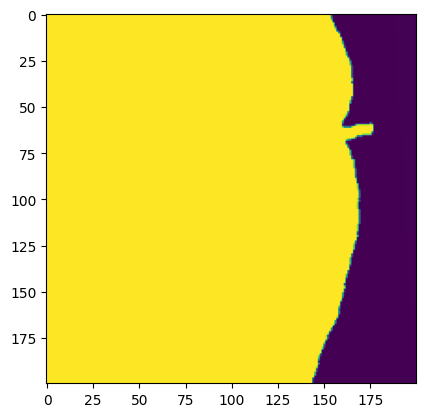

In [6]:
# Verify that image_augmentor applies the desired transformations
img = read_image('images/1.jpg', mode=ImageReadMode.GRAY)
out = [image_augmentor(img) for _ in range(5)]

plt.imshow(out[0][0])

#### Image Preprocessing

In [7]:
# Returns the preprocessed image as a 2D numpy array
def load_image(filename):
    img = read_image(filename, mode=ImageReadMode.GRAY)
    return image_resizer(img)[0].numpy()

# Returns a 2D numpy arrays from the augmented images
def augment_image(filename):
    img = read_image(filename, mode=ImageReadMode.GRAY)
    return image_augmentor(img)[0].numpy()

# Loads images with specified indices into one-dimensional
# pixel data and concatenates it all into a single dataframe
def images_to_df(indices):
    imgs = [
        load_image(f'images/{i}.jpg') for i in indices
    ]

    # Converts each image to flat 1D representation
    df = pd.DataFrame(
               np.asarray(imgs).reshape((len(imgs), -1))
           ).set_index(indices)
    df.columns = df.columns.astype(str)     # Prevents some obscure errors later
    return df

In [8]:
# Load the data corresponding to each dataset
img_train_df = images_to_df(train_df.index)
img_test_df = images_to_df(test_df.index)

img_train_df = img_train_df.astype(int)
img_test_df = img_test_df.astype(int)

#### Data Preprocessing Pipelines

In [9]:
# Specify the type of each column for us to know what preprocessing needs to be done to each column
passthrough_features = [i for i in img_train_df]   # img_train columns are not manually preprocessed

# All other non-image/non-y features are numeric
numeric_features = list(set([i for i in train_df.drop(columns='species').columns]) - set(passthrough_features))
binary_features = []

In [10]:
# Define the pipelines for each type of data we have
numeric_pipeline = make_pipeline(
    # Normalize all of them to unit norm
    Normalizer()
)

# Define our column transformer/preprocessor itself
preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    ('passthrough', passthrough_features),
)

#### Concatenated Dataframes & Column Transformations

In [11]:
# Concatenates the image data with the metadata into one dataframe
full_train_df = pd.concat([train_df, img_train_df], axis=1)
full_test_df = pd.concat([test_df, img_test_df], axis=1)

# We want to split X (big X because it is a matrix) and y from each other
full_X_train = full_train_df.drop(columns=['species'])
full_y_train = full_train_df['species']

# Funnily enough, the test has no ground truth...
full_X_test = full_test_df

# Now we want to fit our preprocessor onto our data, so we can actually transform it (then cast it to a DF)
full_X_train_transformed = pd.DataFrame(preprocessor.fit_transform(full_X_train))
full_X_test_transformed = pd.DataFrame(preprocessor.transform(full_X_test))

In [12]:
print(full_y_train.shape)

(990,)


### Train/Validation Set Generation with Data Augmentation

In [13]:
# Splits into training and validation based on data that hasn't been preprocessed yet (this is important)
X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.1, random_state=42)

#### Perform Data Augmentation

In [14]:
# Performs data augmentation and saves the metadata + augmented image data to a list
# NOTE that these next two cells require a lotta RAM so adjust AUGMENTED_ORIGINAL_RATIO if needed
# TODO make function
x_aug = []
y_aug = []
for idx in X_train.index:
    for _ in range(AUGMENTED_ORIGINAL_RATIO):
        augmented_img = augment_image(f'images/{idx}.jpg')
        row = X_train.loc[idx].to_list()
        row[-N_PIXELS:] = augmented_img.reshape(-1)
        x_aug.append(row)
        y_aug.append(y_train.loc[idx])

In [15]:
# Creates an actual dataframe containing all of the data
# One unfortunate side-effect is that index information is lost on augmented data only
X_train_augmented = pd.concat([
    X_train,
    pd.DataFrame(
        x_aug,
        index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
        columns=X_train.columns
    )
])

y_train_augmented = pd.concat([
    y_train,
    pd.Series(y_aug,
              index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
              name=y_train.name)
])


In [17]:
print(X_train_augmented.shape)
print(y_train_augmented.shape)

(5346, 40192)
(5346,)


#### Train/Validation Set Preprocessing

In [23]:
# Shuffle train data so that the augmented data for one image are not all right next to each other
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

# Only fit on the available train data
X_train_augmented_transformed = pd.DataFrame(preprocessor.fit_transform(X_train_augmented), columns=full_X_train.columns)
X_val_transformed = pd.DataFrame(preprocessor.transform(X_val), columns=full_X_train.columns)
X_test_transformed = pd.DataFrame(preprocessor.transform(full_X_test), columns=full_X_train.columns)

#### Save the pre-processed data to csv for access in other jupyter notebooks

In [25]:
if not os.path.exists('CSV/pre-processed/training'):
    os.makedirs('CSV/pre-processed/training')

# These are a whole quarter of a GB lol
X_train_augmented_transformed.to_csv('CSV/pre-processed/training/X_train_augmented.csv')
y_train_augmented.to_csv('CSV/pre-processed/training/y_train_augmented.csv')

In [ ]:
X_val_transformed.to_csv('CSV/pre-processed/training/X_validation_augmented.csv')
y_val.to_csv('CSV/pre-processed/training/y_validation_augmented.csv')

X_test_transformed.to_csv('CSV/pre-processed/training/X_test_augmented.csv')

### Full Train Set Data Augmentation

In [26]:
# Saves augmentation to a list
x_aug = []
y_aug = []
for idx in full_X_train.index:
    for _ in range(AUGMENTED_ORIGINAL_RATIO):
        augmented_img = augment_image(f'images/{idx}.jpg')
        row = full_X_train.loc[idx].to_list()
        row[-N_PIXELS:] = augmented_img.reshape(-1)
        x_aug.append(row)
        y_aug.append(full_y_train.loc[idx])

In [29]:
# Concatenates the lists as dataframes
full_X_train_augmented = pd.concat([
    full_X_train,
    pd.DataFrame(
        x_aug,
        index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
        columns=X_train.columns
    )
])

full_y_train_augmented = pd.concat([
    full_y_train,
    pd.Series(y_aug,
              index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
              name=y_train.name)
])

In [30]:
print(full_X_train_augmented.shape)
print(full_y_train_augmented.shape)

(5940, 40192)
(5940,)


In [31]:
# Shuffle train data so that the augmented versions of one image are not all right next to each other
full_X_train_augmented, full_y_train_augmented = shuffle(full_X_train_augmented, full_y_train_augmented)

# Only fit on the available train data
full_X_train_final = pd.DataFrame(preprocessor.fit_transform(full_X_train_augmented), columns=full_X_train.columns)
full_X_test_final = pd.DataFrame(preprocessor.transform(full_X_test), columns=full_X_train.columns)

In [32]:
# Output to 
if not os.path.exists('CSV/pre-processed/training'):
    os.makedirs('CSV/pre-processed/training')

full_X_train_final.to_csv('CSV/pre-processed/training/full_X_train_augmented.csv')
full_y_train_augmented.to_csv('CSV/pre-processed/training/full_y_train_augmented.csv')
full_X_test_final.to_csv('CSV/pre-processed/training/full_X_test_augmented.csv')